In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import nltk
#nltk.download()
from nltk.corpus import stopwords
import re
import logging  ## Import the built-in logging module and configure it so that Word2Vec creates nice output messages
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
unlabelled_train = pd.read_csv(r"unlabeledTrainData.tsv", header =0, delimiter = "\t", quoting=3 )
train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
unlabelled_train.shape
train.shape

(25000, 3)

In [4]:
pd.set_option('display.max_colwidth', -1)
unlabelled_train.head()

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was made by a bunch of friends. Maybe they were sitting around one day in film school and said, \""Hey, let's pool our money together and make a really bad movie!\"" Or something like that. What ever they said, they still ended up making a really bad movie--dull story, bad script, lame acting, poor cinematography, bottom of the barrel stock music, etc. All corners were cut, except the one that would have prevented this film's release. Life's like that."""
1,"""45057_0""","""I saw this film about 20 years ago and remember it as being particularly nasty. I believe it is based on a true incident: a young man breaks into a nurses' home and rapes, tortures and kills various women.<br /><br />It is in black and white but saves the colour for one shocking shot.<br /><br />At the end the film seems to be trying to make some political statement but it just comes across as confused and obscene.<br /><br />Avoid."""
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan Barnard (Elvire Audrey) is informed that her husband, the archeologist Arthur Barnard (John Saxon), was mysteriously murdered in Italy while searching an Etruscan tomb. Joan decides to travel to Italy, in the company of her colleague, who offers his support. Once in Italy, she starts having visions relative to an ancient people and maggots, many maggots. After shootings and weird events, Joan realizes that her father is an international drug dealer, there are drugs hidden in the tomb and her colleague is a detective of the narcotic department. The story ends back in New York, when Joan and her colleague decide to get married with each other, in a very romantic end. Yesterday I had the displeasure of wasting my time watching this crap. The story is so absurd, mixing thriller, crime, supernatural and horror (and even a romantic end) in a non-sense way. The acting is the worst possible, highlighting the horrible performance of the beautiful Elvire Audrey. John Saxon just gives his name to the credits and works less than five minutes, when his character is killed. The special effects are limited to maggots everywhere. The direction is ridiculous. I lost a couple of hours of my life watching 'Assassinio al Cimitero Etrusco'. If you have the desire or curiosity of seeing this trash, choose another movie, go to a pizzeria, watch TV, go sleep, navigate in Internet, go to the gym, but do not waste your time like I did. My vote is two.<br /><br />Title (Brazil): 'O Mistério Etrusco' ('The Etruscan Mystery')"""
3,"""7161_0""","""I went to see this film with a great deal of excitement as I was at school with the director, he was even a good friend of mine for a while. But sorry mate, this film stinks.<br /><br />I can only talk about what was wrong with the first half because that's when I walked out and went to the pub for a much needed drink:<br /><br />1) someone's standing on a balcony about to jump and so you send a helicopter to shine a searchlight on them??? I don't think so - nothing would make them more likely to jump.<br /><br />2) local radio doesn't send reporters to cover people about to attempt suicide - again for fear of pressuring them into jumping - or for fear of encouraging copy-cat instances.<br /><br />3) whatever the circumstances, radio reporters don't do live broadcasts from the 10th floor of a tower block. Radio cars don't carry leads long enough to connect the microphone and headphones to the transmitter.<br /><br />4) the stuck in the lift scene was utterly derivative<br /><br />5) the acting and direction was almost non existent.<br /><br />I could go on, but I won't."""
4,"""43971_0""","""Yes, I agree with everyone on this site this movie is VERY VERY bad. To even call this a movie is an insult to all movies ever made. It's 40 minutes long.<br /><br />Someone compares this movie to an after school special. B-I-N-G-O! That describes is perfectly.<br /><br />The packaging for thi

##### Clean the data and return the list of words

- The functions we write to clean the data are also similar to bag of words, although now there are a couple of differences. - - First, to train Word2Vec it is better not to remove stop words because the algorithm relies on the broader context of the sentence in order to produce high-quality word vectors. 
- For this reason, we will make stop word removal optional in the functions below. 
- It also might be better not to remove numbers, but we do that later.

In [5]:
def review_to_wordlist(review, remove_stopwords=False) :
    # 1. Remove HTML tags
    review_text = BeautifulSoup(review).get_text()
    # 2. Remove non alphabetical characters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    # 3. lower-case the text and split it into words
    words = letters_only.lower().split()
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords :
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    # 5. Return a list of words
    return(words)

- Word2Vec expects single sentences, each one as a list of words. 
- In other words, the input format is a list of lists.

In [6]:
# Load the punkt tokenizer
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

In [7]:
# Define a function to split a review into parsed sentences

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0 :
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
            
    # 3. Return the list of sentences ( each sentence is a list of words, so this returns list of lists)
    return sentences
            
    

In [8]:
rawS = tokenizer.tokenize(train["review"][0])
rawS

['"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again.',
 'Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent.',
 'Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released.',
 "Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring.",
 'Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit 

##### Now we can apply the above function to prepare our data for input to Word2Vec

In [10]:
sentences = []
for review in train["review"] :
    sentences += review_to_sentences(review, tokenizer)
for review in unlabelled_train["review"] :
    sentences += review_to_sentences(review,tokenizer)
    
len(sentences)

C:\Users\sahit\Anaconda3\envs\pvnd_ml\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'....'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\sahit\Anaconda3\envs\pvnd_ml\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.msnbc.msn.com/id/4972055/site/newsweek/"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\sahit\Anaconda3\envs\pvnd_ml\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\sahit\Anaconda3\envs\pvnd_ml\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.youtube.com/watch?v=a0

795538

In [11]:
sentences[0:10]

[['with',
  'all',
  'this',
  'stuff',
  'going',
  'down',
  'at',
  'the',
  'moment',
  'with',
  'mj',
  'i',
  've',
  'started',
  'listening',
  'to',
  'his',
  'music',
  'watching',
  'the',
  'odd',
  'documentary',
  'here',
  'and',
  'there',
  'watched',
  'the',
  'wiz',
  'and',
  'watched',
  'moonwalker',
  'again'],
 ['maybe',
  'i',
  'just',
  'want',
  'to',
  'get',
  'a',
  'certain',
  'insight',
  'into',
  'this',
  'guy',
  'who',
  'i',
  'thought',
  'was',
  'really',
  'cool',
  'in',
  'the',
  'eighties',
  'just',
  'to',
  'maybe',
  'make',
  'up',
  'my',
  'mind',
  'whether',
  'he',
  'is',
  'guilty',
  'or',
  'innocent'],
 ['moonwalker',
  'is',
  'part',
  'biography',
  'part',
  'feature',
  'film',
  'which',
  'i',
  'remember',
  'going',
  'to',
  'see',
  'at',
  'the',
  'cinema',
  'when',
  'it',
  'was',
  'originally',
  'released'],
 ['some',
  'of',
  'it',
  'has',
  'subtle',
  'messages',
  'about',
  'mj',
  's',
  'feeli

- A minor detail to note is the difference between the "+=" and "append" when it comes to Python lists. 
- In many applications the two are interchangeable, but here they are not.
- If you are appending a list of lists to another list of lists, "append" will only append the first list; you need to use "+=" in order to join all of the lists at once.

##### Training and Saving Your Model

- __Architecture__: Architecture options are skip-gram (default) or continuous bag of words. We found that skip-gram was very slightly slower but produced better results.
- __Training algorithm__: Hierarchical softmax (default) or negative sampling. For us, the default worked well.
- __Downsampling of frequent words__: The Google documentation recommends values between .00001 and .001. For us, values closer 0.001 seemed to improve the accuracy of the final model.
- __Word vector dimensionality__: More features result in longer runtimes, and often, but not always, result in better models. Reasonable values can be in the tens to hundreds; we used 300.
- __Context / window size__: How many words of context should the training algorithm take into account? 10 seems to work well for hierarchical softmax (more is better, up to a point).
- __Worker threads__: Number of parallel processes to run. This is computer-specific, but between 4 and 6 should work on most systems.
- __Minimum word count__: This helps limit the size of the vocabulary to meaningful words. Any word that does not occur at least this many times across all documents is ignored. Reasonable values could be between 10 and 100. In this case, since each movie occurs 30 times, we set the minimum word count to 40, to avoid attaching too much importance to individual movie titles. This resulted in an overall vocabulary size of around 15,000 words. Higher values also help limit run time.

- https://towardsdatascience.com/fasttext-under-the-hood-11efc57b2b3
- http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/

In [12]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

In [13]:
# Set values for various parameters

num_features = 300  # word vector dimensionality
min_word_count = 40 # minimum word count
num_workers = 4 # num of threads to run in parallel
context = 10  # window size
downsampling = 1e-3  

In [14]:
# Initialise the train model
from gensim.models import word2vec
model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)


ModuleNotFoundError: No module named 'gensim'

In [66]:
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.

model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

2019-08-27 18:25:15,688 : INFO : precomputing L2-norms of word weight vectors
2019-08-27 18:25:15,870 : INFO : saving Word2Vec object under 300features_40minwords_10context, separately None
2019-08-27 18:25:15,871 : INFO : not storing attribute vectors_norm
2019-08-27 18:25:15,872 : INFO : not storing attribute cum_table
C:\Users\SAkela\AppData\Local\Continuum\anaconda3\envs\sahithi_ml\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-08-27 18:25:16,359 : INFO : saved 300features_40minwords_10context


In [67]:
model.doesnt_match("man woman child kitchen".split())

C:\Users\SAkela\AppData\Local\Continuum\anaconda3\envs\sahithi_ml\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
C:\Users\SAkela\AppData\Local\Continuum\anaconda3\envs\sahithi_ml\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'kitchen'

In [68]:
model.doesnt_match("england paris france germany berlin".split())

C:\Users\SAkela\AppData\Local\Continuum\anaconda3\envs\sahithi_ml\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'paris'

In [69]:
model.doesnt_match("paris london berlin austria".split())

C:\Users\SAkela\AppData\Local\Continuum\anaconda3\envs\sahithi_ml\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'paris'

In [70]:
model.most_similar("paris")

C:\Users\SAkela\AppData\Local\Continuum\anaconda3\envs\sahithi_ml\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('vienna', 0.6541231870651245),
 ('france', 0.646237850189209),
 ('berlin', 0.6296929121017456),
 ('california', 0.6215904951095581),
 ('rome', 0.619369387626648),
 ('montreal', 0.6179684400558472),
 ('budapest', 0.6105321049690247),
 ('austria', 0.6087332963943481),
 ('london', 0.6056917905807495),
 ('italy', 0.6016755104064941)]

In [71]:
model.most_similar("queen")

C:\Users\SAkela\AppData\Local\Continuum\anaconda3\envs\sahithi_ml\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('princess', 0.6691408753395081),
 ('bride', 0.6129081845283508),
 ('victoria', 0.6065695881843567),
 ('duchess', 0.606062114238739),
 ('stepmother', 0.5998979210853577),
 ('latifah', 0.5845532417297363),
 ('maid', 0.5796114206314087),
 ('maria', 0.5773558020591736),
 ('goddess', 0.5766826272010803),
 ('dame', 0.5723810195922852)]

In [80]:
# plot the clusters


keys = ["man", "queen", "drugs", "thriller", "supernatural", "movies", "character"]

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)



C:\Users\SAkela\AppData\Local\Continuum\anaconda3\envs\sahithi_ml\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
C:\Users\SAkela\AppData\Local\Continuum\anaconda3\envs\sahithi_ml\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [81]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
print(n,m,k)

7 30 300


In [82]:
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

2019-08-27 18:45:22,726 : WARNING : 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2019-08-27 18:45:22,746 : WARNING : 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2019-08-27 18:45:22,753 : WARNING : 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2019-08-27 18:45:22,762 : WARNING : 'c' arg

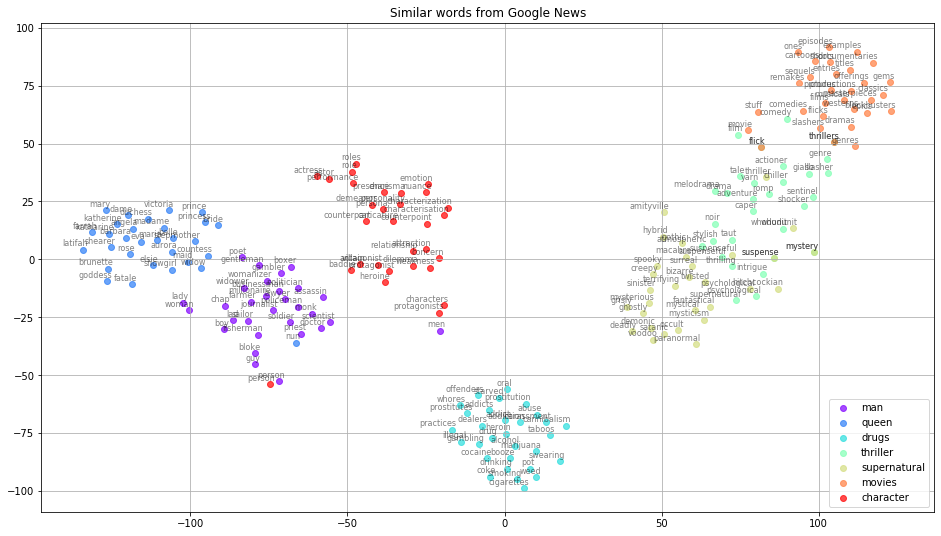

In [84]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

In [ ]:
model = Word2Vec.load("300features_40minwords_10context")